##1.2 Install and load libraries

In [1]:
!pip install wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 249.2/249.2 kB 16.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.0 MB/s eta 0:00:00


In [ ]:
import wandb
import pandas as pd
import numpy as np
import tempfile
import logging
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

##1.3 Preprocessing

###1.3.1 Download raw_data artifact from Wandb

In [ ]:
# Login to Weights & Biases
!wandb login --relogin

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
input_artifact="students_adaptability/raw_data.csv:latest"
artifact_name="preprocessed_data.csv"
artifact_type="clean_data"
artifact_description="Data after preprocessing"

###1.3.2 Setup wandb project and clean the dataset

In [ ]:
# create a new job_type
run = wandb.init(project="students_adaptability", job_type="process_data")

In [ ]:
# donwload the latest version of artifact raw_data.csv
artifact = run.use_artifact(input_artifact)

# create a dataframe from the artifact
df = pd.read_csv(artifact.file())

In [ ]:
# Delete duplicated rows
df.drop_duplicates(inplace=True)

# Generate a "clean data file"
df.to_csv(artifact_name,index=False)

###1.3.3 Some Data Analisys

In [ ]:
df.info()

In [ ]:
df.head()

<Axes: >

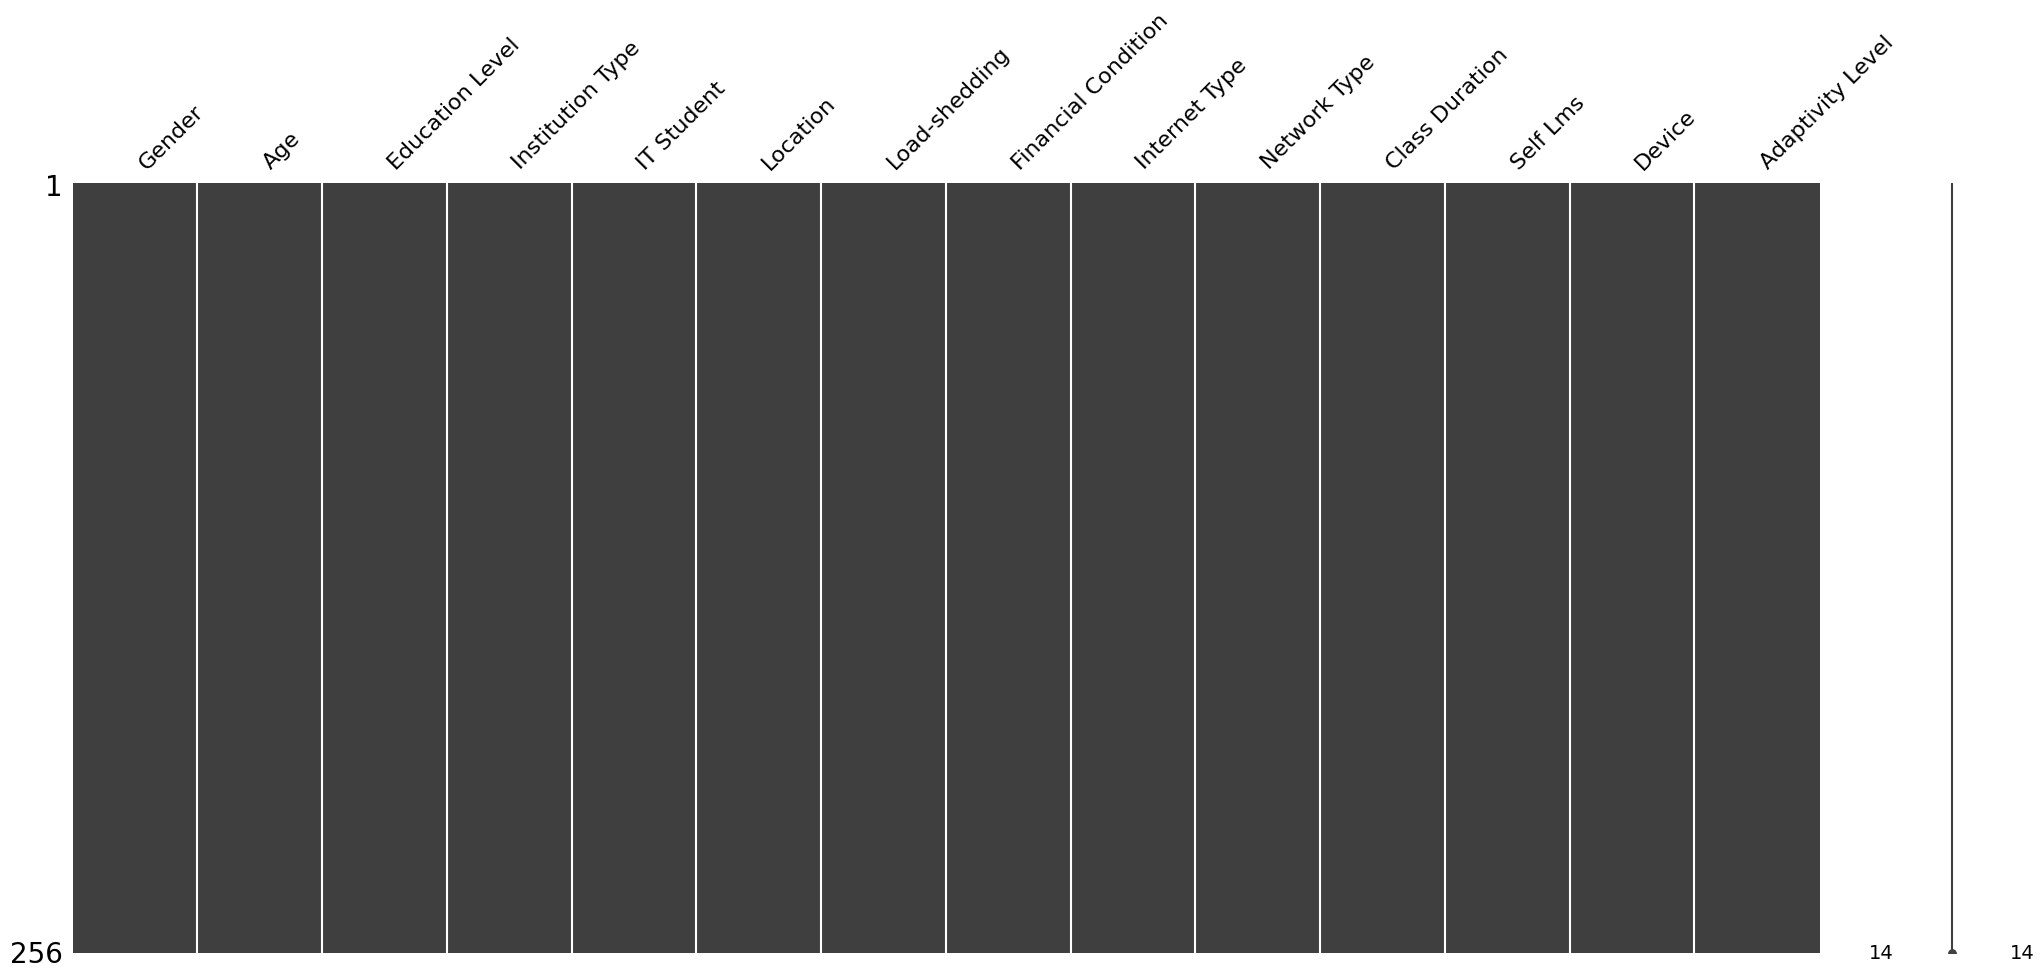

In [ ]:
# Show missing data

import missingno as msno
msno.matrix(df)

In [ ]:
df.dtypes

Gender                 object
Age                    object
Education Level        object
Institution Type       object
IT Student             object
Location               object
Load-shedding          object
Financial Condition    object
Internet Type          object
Network Type           object
Class Duration         object
Self Lms               object
Device                 object
Adaptivity Level       object
dtype: object

In [ ]:
# Resume the colums, the .T change colums to rows.
df.describe().T

,count,unique,top,freq
Gender,256,2,Boy,148
Age,256,6,21-25,101
Education Level,256,3,University,121
Institution Type,256,2,Non Government,152
IT Student,256,2,No,178
Location,256,2,Yes,182
Load-shedding,256,2,Low,202
Financial Condition,256,3,Mid,183
Internet Type,256,2,Mobile Data,138
Network Type,256,3,4G,161


In [ ]:
for i in df.columns:
    print(i, ":", df[i].unique().tolist())

<Axes: ylabel='Adaptivity Level'>

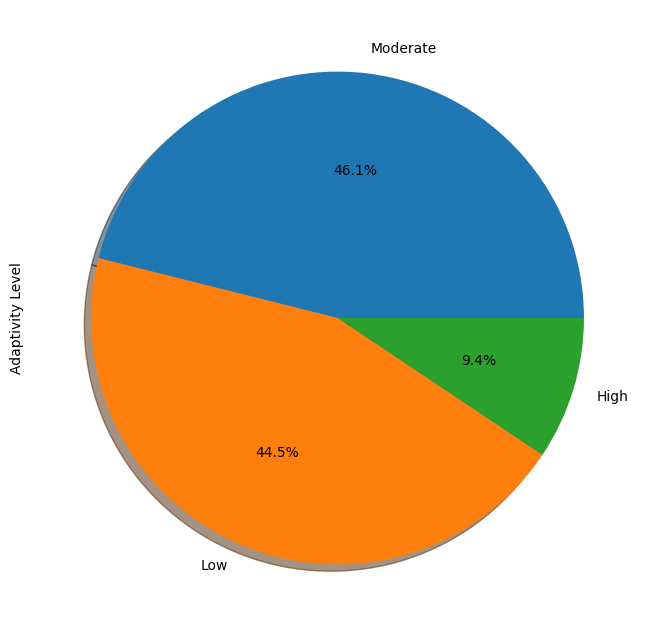

In [ ]:
# Show the percentage of Adaptivity

plt.figure(figsize=(12,8))
df['Adaptivity Level'].value_counts().plot.pie(autopct='%1.1f%%',shadow=True)

###1.3.4 Tranform values contegoring in numerics

In [ ]:
# Convert categorical in numeric using LabelEncode

data = df

label_encoders = {}
categorical_columns = data.columns

for column in categorical_columns:
    label_encoders[column] = LabelEncoder()
    data[column] = label_encoders[column].fit_transform(data[column])

In [ ]:
data.head()

,Gender,Age,Education Level,Institution Type,IT Student,Location,Load-shedding,Financial Condition,Internet Type,Network Type,Class Duration,Self Lms,Device,Adaptivity Level
0,0,3,2,1,0,1,1,0,1,2,2,0,2,2
1,1,3,2,1,0,1,0,0,0,2,1,1,1,2
2,1,2,0,0,0,1,1,0,1,2,1,0,1,2
3,1,1,1,1,0,1,1,0,0,2,1,0,1,2
4,1,2,1,1,0,1,1,1,0,1,0,0,1,1


In [ ]:
# configure logging
logging.basicConfig(level=logging.INFO,
                    format="%(asctime)s %(message)s",
                    datefmt='%d-%m-%Y %H:%M:%S')

# reference for a logging obj
logger = logging.getLogger()
with tempfile.TemporaryDirectory() as tmp_dir:
        temp_path = os.path.join(tmp_dir, artifact_name)
        data.to_csv(temp_path,index=False)

        artifact = wandb.Artifact(name=artifact_name,
                                  type=artifact_type,
                                  description="pre processed data",
        )

        artifact.add_file(temp_path)

        logger.info("Logging artifact")
        run.log_artifact(artifact)

        # This waits for the artifact to be uploaded to W&B. If you
        # do not add this, the temp directory might be removed before
        # W&B had a chance to upload the datasets, and the upload
        # might fail
        artifact.wait()

In [ ]:
# Upload the artifact to Wandb
run.log_artifact(artifact)

<Artifact QXJ0aWZhY3Q6NjQ1MTA1NTk0>

In [ ]:
# close the run
# waiting a while after run the previous cell before execute this
run.finish()